# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("WineKMC.xlsx", sheet_name=0)

### 1b. Explore the data

In [3]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [5]:
df = pd.merge(df_offers, df_transactions)
matrix = df.pivot_table(index = ['customer_name'], columns = ['offer_id'], values = 'n')
matrix = matrix.fillna(0).reset_index()

offer_cols = matrix.columns[1:]

## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

For better clusterings, we want a low $SS$ value as the $(x_i - \mu_k)$ term represents the distance between a data point and the centroid of the cluster, which we are trying to minimize. As the number of clusters, $K$, increases, $SS$ will decrease but it will not be helpful if $SS$ goes all the way down to 0. When $SS = 0$, there is a cluster for every data point, and thus will be a case of overfitting. 

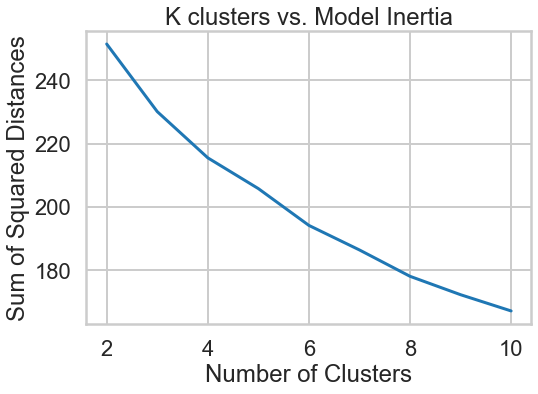

In [6]:
# your turn
import numpy as np
from sklearn.cluster import KMeans

x_cols =  matrix.iloc[:, 1:]
k_vals = list(range(2,11))
ss_vals = []

for k in k_vals:
    model = KMeans(n_clusters = k)
    model.fit(x_cols)
    ss_vals.append(model.inertia_)

plt.figure(figsize=(8,6))
plt.plot(k_vals, ss_vals)
plt.title('K clusters vs. Model Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.tight_layout()

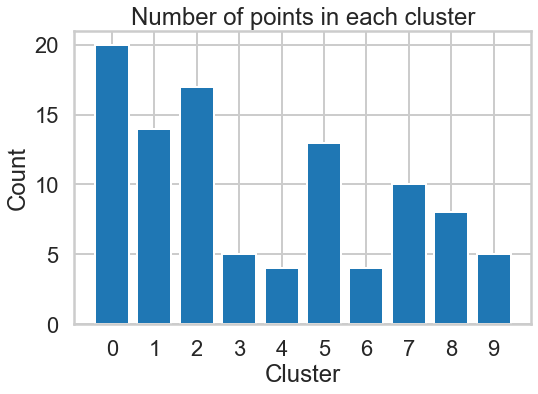

In [7]:
cluster_labels, counts = np.unique(model.labels_, return_counts = True)
plt.figure(figsize = (8,6))
plt.bar(cluster_labels, counts, align = 'center', tick_label = cluster_labels)
plt.title('Number of points in each cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.tight_layout()

The main challenge with the Elbow method was that judging from the $K$ vs. $SS$ graph, it was hard to tell exactly where there was a dropoff in the decrease in the sum of squared distances. With every increase in the number of clusters, there was a relatively constant decrease in the $SS$ value, so there was no clear indication on how many clusters that should be used.

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For K = 2, the average silhouette score is: 0.0901
For K = 3, the average silhouette score is: 0.108
For K = 4, the average silhouette score is: 0.1357
For K = 5, the average silhouette score is: 0.1345
For K = 6, the average silhouette score is: 0.1149
For K = 7, the average silhouette score is: 0.1262
For K = 8, the average silhouette score is: 0.1204
For K = 9, the average silhouette score is: 0.1177
For K = 10, the average silhouette score is: 0.126


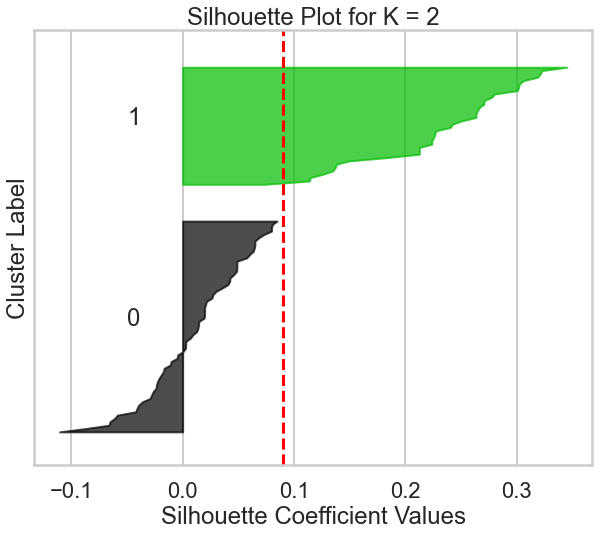

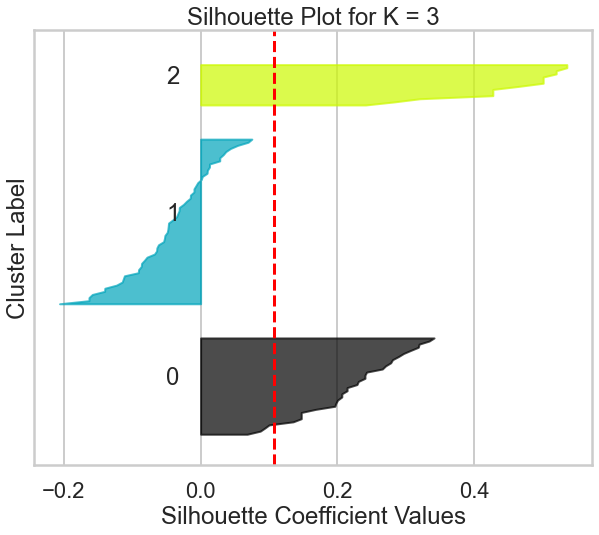

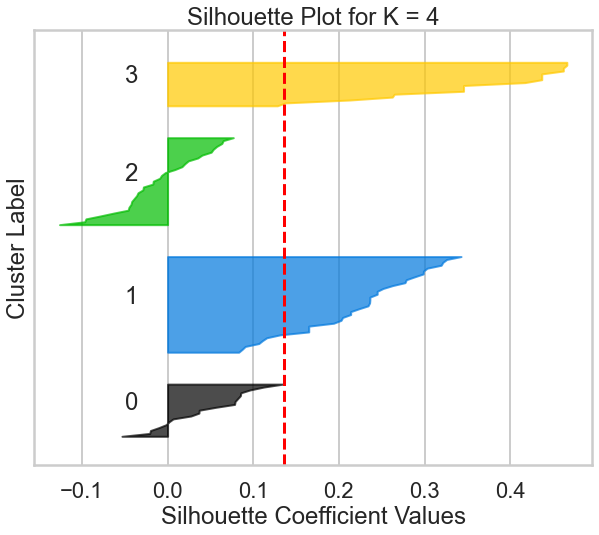

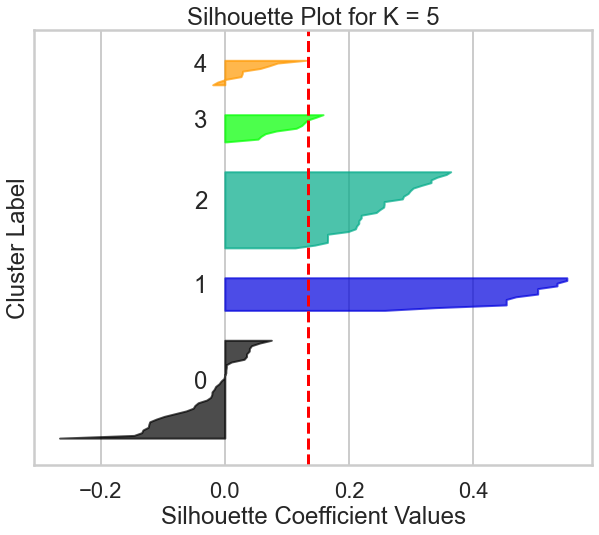

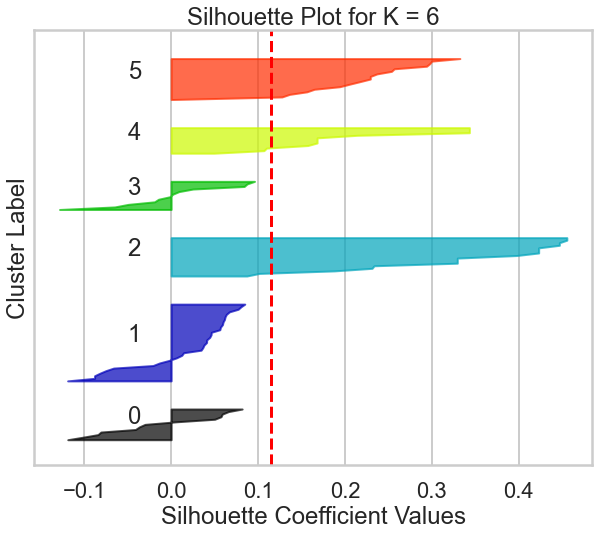

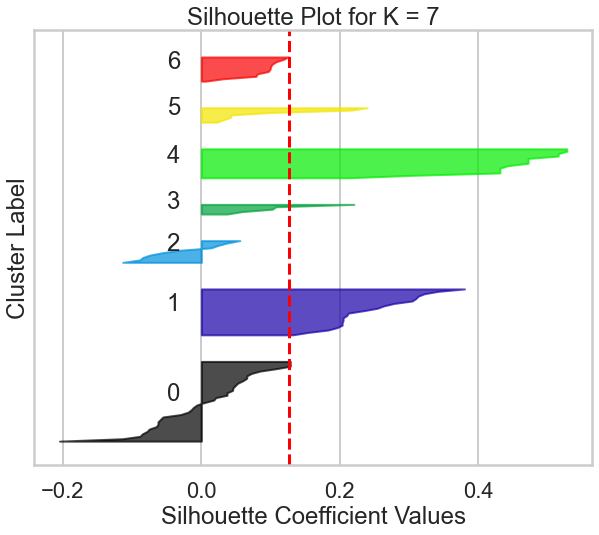

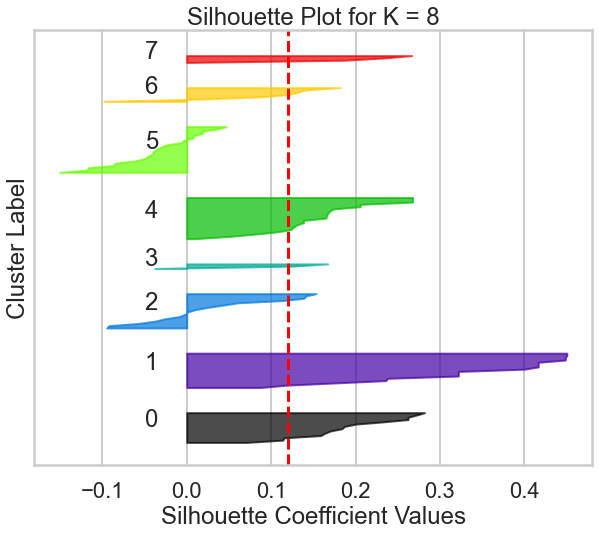

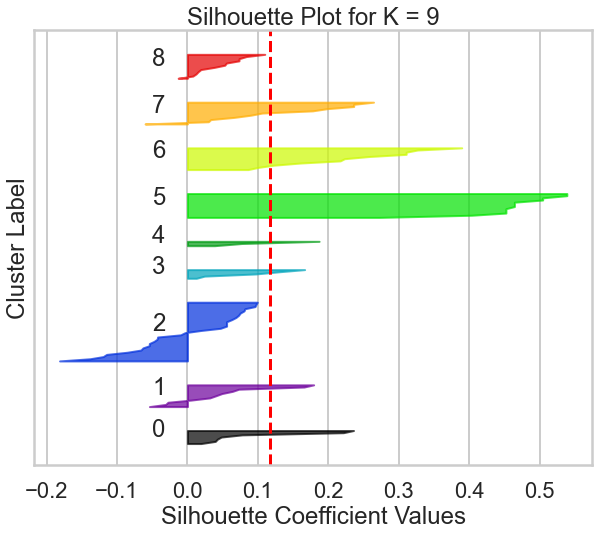

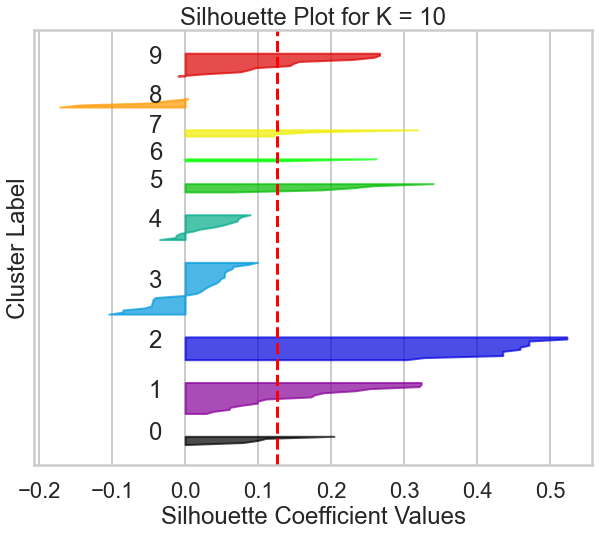

In [8]:
# Your turn.
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

for k in k_vals:
    plt.figure(figsize = (10,8))
    
    plt.ylim([0, len(x_cols)+(k+1)*10])
    
    model = KMeans(n_clusters = k)
    labels = model.fit_predict(x_cols)
    
    silhouette_avg = silhouette_score(x_cols, labels)
    print(f'For K = {k}, the average silhouette score is: {round(silhouette_avg, 4)}')
    
    sample_silhouette_values = silhouette_samples(x_cols, labels)
    
    y_lower = 10
    
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title(f"Silhouette Plot for K = {k}")
    plt.xlabel("Silhouette Coefficient Values")
    plt.ylabel("Cluster Label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    plt.yticks([])  # Clear the yaxis labels / ticks   

From the average silhouette scores, we should use $K = 6$ clusters. Although using 6 clusters returned the highest average silhouette score, a score of 0.1501 means that there was no substantial structure found in the data and thus cannot be accurately used for customer segmentation in this case.

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

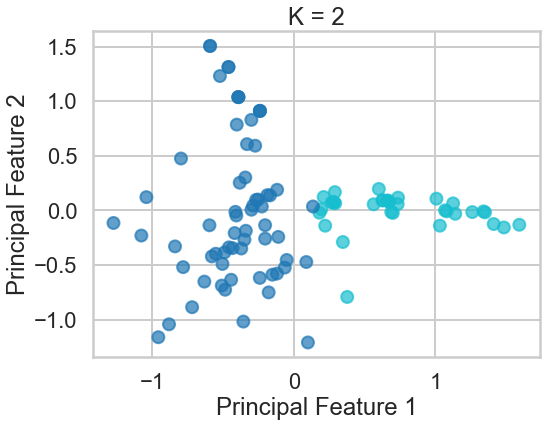

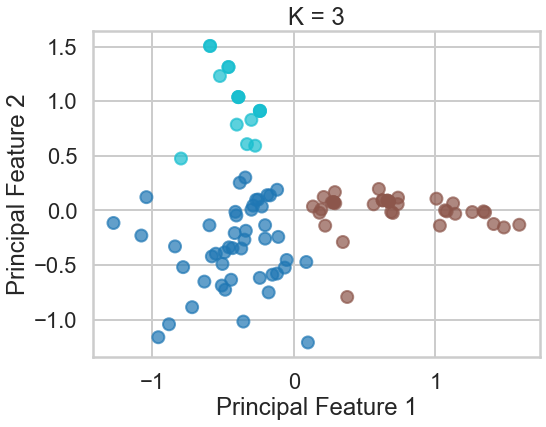

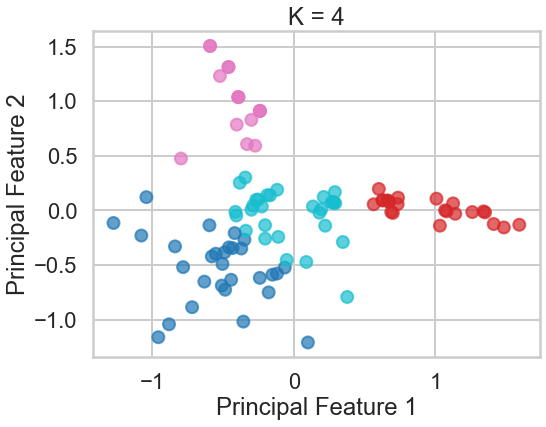

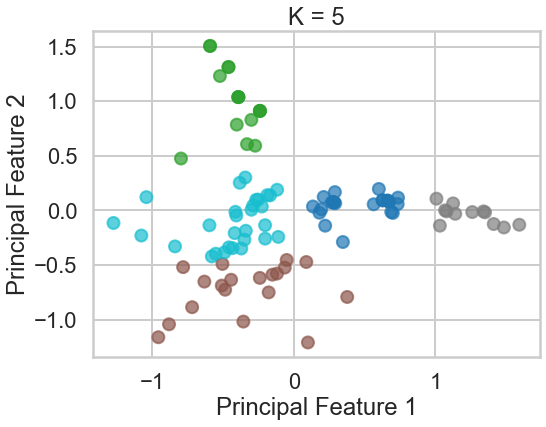

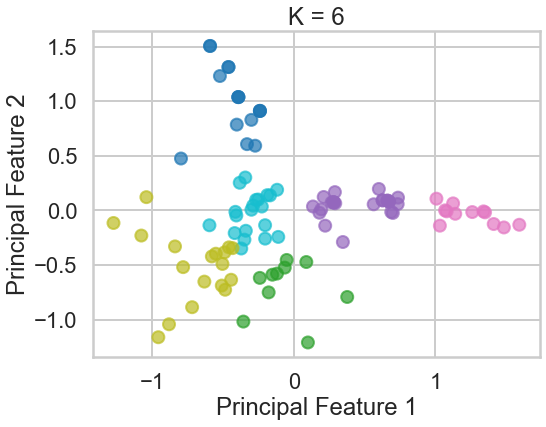

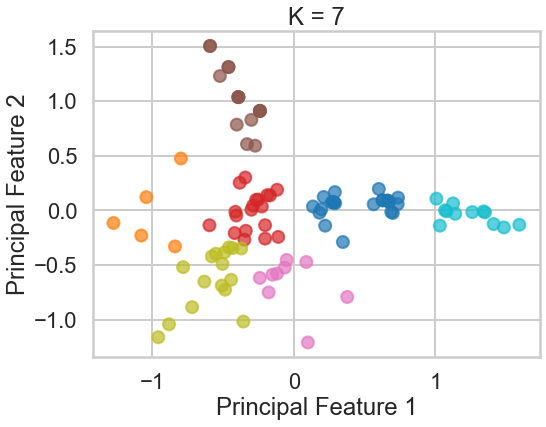

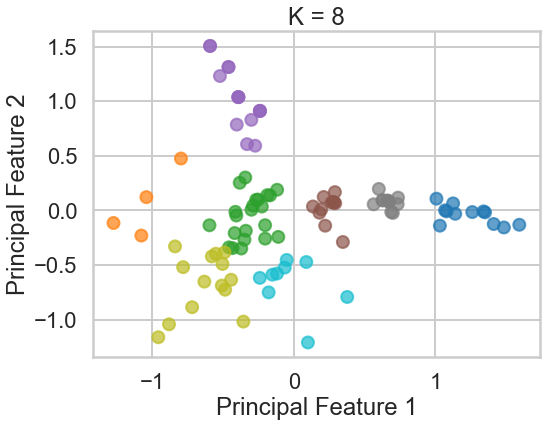

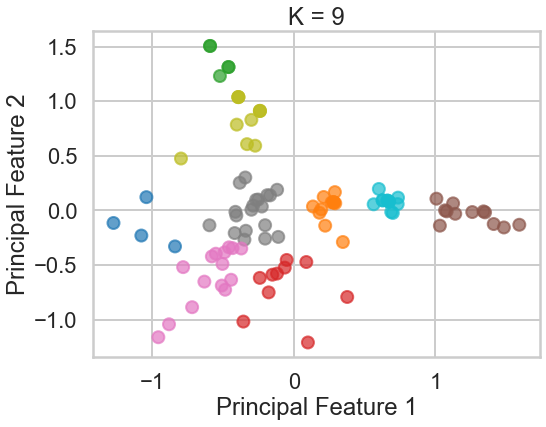

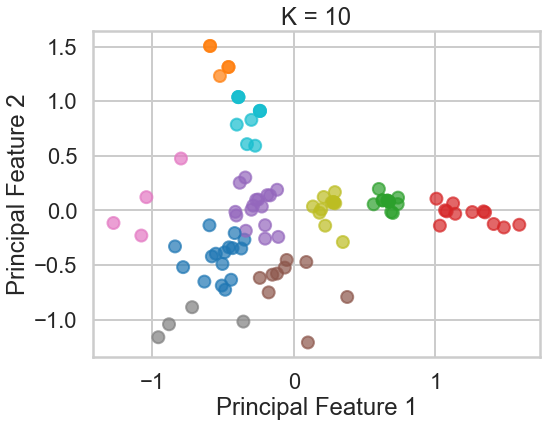

In [9]:
#your turn
from sklearn.decomposition import PCA

sns.set_palette('tab10')
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(x_cols)


matrix['x'] = principalComponents[:,0]
matrix['y'] = principalComponents[:,1]
matrix = matrix.reset_index()

for k in k_vals:
    model = KMeans(n_clusters = k)
    labels = model.fit_predict(matrix[['x','y']])
    matrix['k_'+str(k)] = labels
    
    plt.figure(figsize = (8,6))
    
    plt.scatter(matrix['x'], matrix['y'], c = matrix['k_'+str(k)], cmap = 'tab10', alpha = 0.7)
    plt.title(f'K = {k}')
    plt.xlabel('Principal Feature 1')
    plt.ylabel('Principal Feature 2')


From a visual standpoint, using $K=6$ seems to return the most optimal clusters. With 7 clusters, the model seems to start overfitting and does not look like it will be able to generalize better than having only 6 clusters. Because of this, using the Silhouette score was a better method of choosing the number of clusters, as with the elbow method, the optimal number of clusters would've been 10 clusters. Although 6 clusters looks more optimal visually, because there's quantitative evidence for 7 clusters, I would segment the customers into 7 different clusters.

In [10]:
customer_clusters = matrix[['customer_name', 'k_6', 'x','y']]

df = pd.merge(df_transactions, customer_clusters)
df = pd.merge(df_offers, df)

df.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,k_6,x,y
0,1,January,Malbec,72,56,France,False,Thomas,1,4,-1.041879,0.122314
1,1,January,Malbec,72,56,France,False,Jackson,1,4,-0.839578,-0.328823
2,1,January,Malbec,72,56,France,False,Mitchell,1,5,-0.342938,0.302186
3,1,January,Malbec,72,56,France,False,Peterson,1,0,-0.797379,0.475995
4,1,January,Malbec,72,56,France,False,Wood,1,4,-0.551215,-0.395670


In [11]:
df.groupby('k_6').varietal.value_counts()

k_6  varietal          
0    Pinot Noir            37
     Prosecco               2
     Champagne              1
     Chardonnay             1
     Malbec                 1
     Merlot                 1
1    Champagne             23
     Espumante              8
     Prosecco               7
     Malbec                 5
     Cabernet Sauvignon     2
     Merlot                 1
2    Espumante             17
     Prosecco              11
     Malbec                 7
     Pinot Grigio           7
     Champagne              3
     Cabernet Sauvignon     2
     Merlot                 2
     Chardonnay             1
3    Espumante             13
     Malbec                11
     Pinot Grigio           9
     Prosecco               8
     Merlot                 5
4    Champagne             38
     Cabernet Sauvignon    14
     Prosecco              12
     Malbec                 7
     Chardonnay             6
     Merlot                 5
     Pinot Noir             5
     Espumante  

In [12]:
df.groupby('k_6')[['min_qty', 'discount']].mean().reset_index()

,k_6,min_qty,discount
0,0,65.581395,52.116279
1,1,54.782609,59.630435
2,2,23.760000,57.060000
3,3,6.000000,54.934783
4,4,88.786517,63.606742
5,5,84.360000,64.940000


In [13]:
df.groupby('k_6').origin.value_counts()

k_6  origin      
0    Australia       13
     Italy           12
     France           7
     Germany          7
     California       2
     New Zealand      1
     South Africa     1
1    France          23
     Oregon           5
     Australia        4
     Germany          4
     South Africa     4
     Chile            3
     California       2
     New Zealand      1
2    France          16
     Oregon           9
     South Africa     9
     Australia        8
     California       4
     Chile            3
     New Zealand      1
3    France          20
     Australia        8
     South Africa     7
     Oregon           6
     Chile            5
4    France          44
     Chile           17
     Italy            7
     California       5
     New Zealand      5
     Australia        4
     Oregon           3
     Germany          2
     South Africa     2
5    France          18
     Chile            9
     Italy            5
     New Zealand      5
     California       

When looking at the original data with respect to the generated clusters, we can see that each cluster has 1-2 wine varieties that most of the customers within that cluster purchased. Of those wine varieties, champagne seems to be the most common all clusters. Another noticeable statistic is that cluster 4 (5th cluster) had signifcantly the lowest minimum quantity purchased. Perhaps increasing the discount offered toward these customers could increase sales as they have the 2nd lowest discount among the 6 clusters. Analyzing the origin by cluster did not return much of an interesting observation. France was the most common nation of origin among all 6 clusters and cluster 1 (2nd cluster) had the most diverse selection of origins.  

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

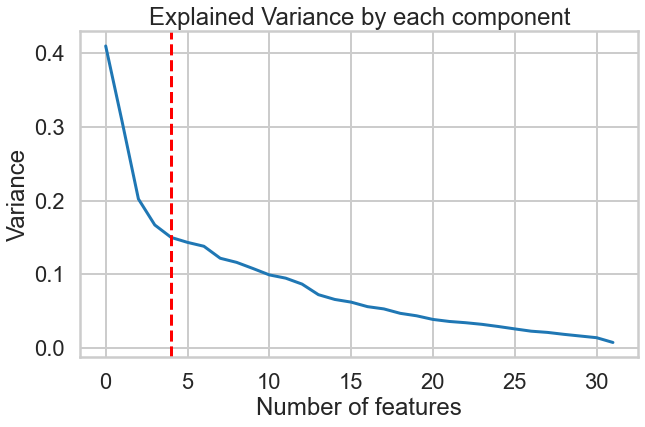

In [14]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)
plt.figure(figsize = (10,6))
plt.plot(list(range(32)), pca.explained_variance_)
plt.title('Explained Variance by each component')
plt.xlabel('Number of features')
plt.ylabel('Variance')
plt.axvline(x = 4, c = 'r', linestyle = '--')
plt.show()

As can be seen by the elbow plot above, there is a steep dropoff in the explained variance after 4 features. This means that decomposing the original dataset into 4 principal components will allow most of the variance in the data to be explained with those principal components.

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

To optimally segment the customers based on the original data, it will be best to use 6 clusters based on the findings from using the Silhouette score and reduce the data into 4 principal components. After clustering the customers, it was evident that a specific group of customers were not purchasing as much as other clusters, quantity wise. Therefore, increasing the discount offered to these customers could potentially increase sales within this cluster. 

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [15]:
# Your turn
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
import warnings

warnings.filterwarnings('ignore')

diff_models = matrix[['customer_name', 'x', 'y']]

ap_model = AffinityPropagation()
spec_cluster = SpectralClustering(n_clusters = 6)
agg_cluster = AgglomerativeClustering(n_clusters = 6)
dbscan = DBSCAN()

models = [ap_model, spec_cluster, agg_cluster, dbscan]
model_names = ['ap_model', 'spec_cluster', 'agg_cluster', 'dbscan']

for i, model in enumerate(models):
    
    tmp_labels = model.fit_predict(x_cols)
    diff_models[model_names[i]] = tmp_labels

In [16]:
diff_models

offer_id,customer_name,x,y,ap_model,spec_cluster,agg_cluster,dbscan
0,Adams,1.007580,0.108215,0,5,1,-1
1,Allen,-0.287539,0.044715,10,1,0,-1
2,Anderson,-0.392032,1.038391,6,0,2,-1
3,Bailey,0.699477,-0.022542,3,3,1,-1
4,Baker,0.088183,-0.471695,3,1,0,-1
...,...,...,...,...,...,...,...
95,Williams,-0.151666,-0.587844,12,1,0,-1
96,Wilson,0.688224,-0.013688,7,4,1,-1
97,Wood,-0.551215,-0.395670,12,1,0,-1
98,Wright,-0.489805,-0.383307,8,2,3,-1


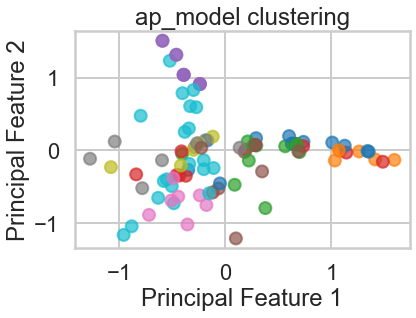

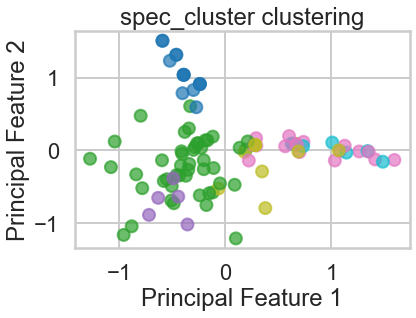

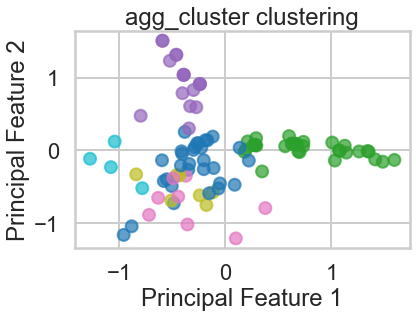

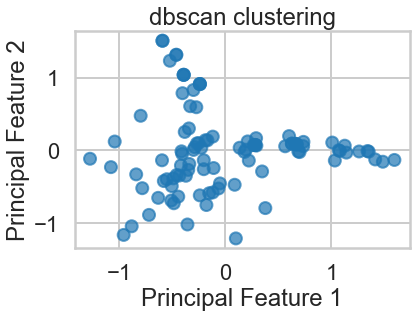

In [17]:
for model in model_names:
    plt.figure()
    plt.scatter(diff_models['x'], diff_models['y'], c = diff_models[model], alpha = 0.7, cmap = 'tab10')
    plt.title(f'{model} clustering')
    plt.xlabel('Principal Feature 1')
    plt.ylabel('Principal Feature 2')

From the cluster visualizations generated above, it can be seen that these models did not perform as well on the dataset as K-Means clustering did. All of the models had overlapping clusters, too many clusters, or didn't work at all. However, these models did not go through proper hyperparameter tuning and instead used the default values, unlike K-Means clustering, therefore results could improve with proper tuning and testing. T